In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")

multiindex = pd.MultiIndex.from_product((["l1", "l2"], y.index), names=["level1", y.index.names[-1]])
y = y.loc[multiindex.get_level_values(-1)]
y.index = multiindex
display(y)

y
level1 ds                   
l1     2007-12-10   9.590761
       2007-12-11   8.519590
       2007-12-12   8.183677
       2007-12-13   8.072467
       2007-12-14   7.893572
...                      ...
l2     2016-01-16   7.817223
       2016-01-17   9.273878
       2016-01-18  10.333775
       2016-01-19   9.125871
       2016-01-20   8.891374

[5810 rows x 1 columns]

In [3]:
import numpy as np
def _make_fake_effect(y):
    
    
    x = np.abs(np.cumsum(np.random.randn(len(y))))
    x = x/np.max(x)
    effect = (1/(1 + (x/0.2)**-1.2)).reshape((-1, 1))
    y = y+effect.reshape((-1, 1))
    x = x.reshape((2, -1, 1))
    effect = effect.reshape((2, -1, 1))
    return x, effect, y

x_effect, effect, y = _make_fake_effect(y)

In [4]:
x_effect.shape

(2, 2905, 1)

In [5]:
from hierarchical_prophet.multivariate.multiindex import (
    series_to_tensor,
    extract_timetensor_from_dataframe,
)

In [6]:
t = (
    y.index.get_level_values(-1).to_timestamp().unique()
    - y.index.get_level_values(-1).to_timestamp().min()
).days.values
t = jnp.array(t).reshape(-1, 1)
y_array = series_to_tensor(y)
y_array.shape

(2, 2905, 1)

In [7]:
t.shape

(2905, 1)

In [8]:
from sktime.transformations.series.fourier import FourierFeatures

X = FourierFeatures(sp_list=[7, 365.25], fourier_terms_list=[3, 10]).fit_transform(y=y_array, X=pd.DataFrame(index=y.index))
X = series_to_tensor(X)
X.shape

(2, 2905, 26)

In [9]:
def get_changepoint_matrix(t, changepoint_t):

    expanded_ts = jnp.tile(t.reshape((-1, 1)), (1, len(changepoint_t)))
    A = (expanded_ts >= changepoint_t.reshape((1, -1))).astype(
        int
    ) * expanded_ts
    cutoff_ts = changepoint_t.reshape((1, -1))
    A = jnp.clip(A - cutoff_ts + 1, 0, None)
    return A

def get_changepoint_timeindexes(t, changepoint_interval : int, changepoint_range : float=0.90):
    len_t = len(t)
    max_t = t.max() * changepoint_range
    changepoint_t = np.arange(0, max_t, changepoint_interval)
    return changepoint_t


def compute_changepoint_design_matrix(t, changepoint_ts):
    """
    Compute the changepoint design matrix.

    Parameters:
        t (ndarray): Time indices for each series.
        changepoint_ts (list): List of changepoint time indices for each series.

    Returns:
        ndarray: Changepoint design matrix.
    """
    t = np.array(t)
    changepoint_ts = [np.array(x) for x in changepoint_ts]
    
    n_changepoint_per_series = [len(x) for x in changepoint_ts]
    changepoint_ts = np.concatenate(changepoint_ts)
    changepoint_design_tensor = []
    changepoint_mask_tensor = []
    for i, n_changepoints in enumerate(n_changepoint_per_series):
        expanded_ts = jnp.tile(t.reshape((-1, 1)), (1, sum(n_changepoint_per_series)))
        A = (expanded_ts >= changepoint_ts.reshape((1, -1))).astype(int) * expanded_ts
        cutoff_ts = (
            (expanded_ts < changepoint_ts.reshape((1, -1))).astype(int) * expanded_ts
        ).max(axis=0)
        A = np.clip(A - cutoff_ts, 0, None)

        start_idx = sum(n_changepoint_per_series[:i])
        end_idx = start_idx + n_changepoints
        mask = np.zeros_like(A)
        mask[:, start_idx:end_idx] = 1

        changepoint_design_tensor.append(A)
        changepoint_mask_tensor.append(mask)

    changepoint_design_tensor = np.stack(changepoint_design_tensor, axis=0)
    changepoint_mask_tensor = np.stack(changepoint_mask_tensor, axis=0)
    return jnp.array(changepoint_design_tensor) * jnp.array(changepoint_mask_tensor)

In [10]:
changepoint_intervals = [350, 277]

changepoint_t = []
for interval in changepoint_intervals:
    changepoint_t.append(get_changepoint_timeindexes(t, changepoint_interval=interval))
    
changepoint_matrix = compute_changepoint_design_matrix(t=t, changepoint_ts=changepoint_t)

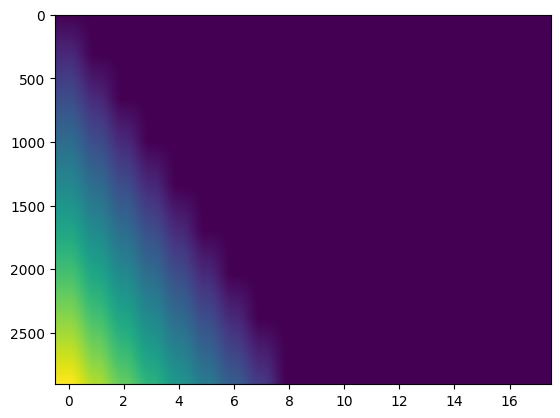

In [11]:
plt.imshow((changepoint_matrix)[0], aspect="auto")

## Code

### Inference Engine

In [12]:
from hierarchical_prophet.engine import MAPInferenceEngine

/Users/fangelim/Documents/personal_workspace/hierarchical_prophet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [89]:
import sys

#  pylint: disable=g-import-not-at-top
from typing import Protocol, TypedDict, Dict


import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from hierarchical_prophet.effects import AbstractEffect
from hierarchical_prophet.hierarchical_prophet._distribution import NormalReconciled


def model(
    t,
    y,
    changepoint_matrix,
    init_trend_params,
    trend_mode,
    data={},
    exogenous_effects: Dict[str, AbstractEffect] = {},
    noise_scale = 0.05,
    y_scale: float = 1,
    corr_matrix_concentration_prior=1,
):
    """
    Defines the Numpyro model.

    Args:
        y (jnp.ndarray): Array of time series data.
        X (jnp.ndarray): Array of exogenous variables.
        t (jnp.ndarray): Array of time values.
    """
    params = init_trend_params()

    # Trend
    changepoint_coefficients = params["changepoint_coefficients"]
    offset = params["offset"]
    capacity = params.get("capacity", None)

    trend = (changepoint_matrix) @ changepoint_coefficients.reshape(
        (1, -1, 1)
    ) + offset.reshape((-1, 1, 1))
    if trend_mode == "logistic":
        trend = capacity.reshape((1, -1, 1)) / (1 + jnp.exp(-trend))

    trend = trend * y_scale.reshape((-1, 1, 1))

    numpyro.deterministic("trend_", trend)

    mean = trend
    # Exogenous effects
    if exogenous_effects is not None:

        for key, exog_effect in exogenous_effects.items():

            exog_data = data[key]
            effect = exog_effect(trend=trend, data=exog_data)
            numpyro.deterministic(key, effect)
            mean += effect

    
    mean = mean.squeeze(-1).T

    std_observation = numpyro.sample(
            "std_observation", dist.HalfNormal(jnp.array([0.1] * mean.shape[0]))
    )

    correlation_matrix = numpyro.sample(
        "corr_matrix",
        dist.LKJCholesky(
            mean.shape[0],
            concentration=corr_matrix_concentration_prior,
        ))

    noise_scale = std_observation * y_scale

    cov_mat = jnp.diag(noise_scale) @ correlation_matrix @ jnp.diag(noise_scale)

    cov_mat = jnp.tile(jnp.expand_dims(cov_mat, axis=0), (mean.shape[1], 1, 1))

    with numpyro.plate("series", mean.shape[0]) as time_plate:
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(mean, scale_tril=cov_mat),
            obs=y,
        )

In [90]:
X

Array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 7.8183150e-01,  6.2348980e-01,  9.7492790e-01, ...,
          9.8803902e-01,  1.7117706e-01,  9.8524028e-01],
        [ 9.7492790e-01, -2.2252093e-01, -4.3388373e-01, ...,
          9.5244223e-01,  3.3730108e-01,  9.4139683e-01],
        ...,
        [-2.5281909e-13,  1.0000000e+00, -5.0563817e-13, ...,
          9.7010469e-01,  4.1301304e-01,  9.1072512e-01],
        [ 7.8183150e-01,  6.2348980e-01,  9.7492790e-01, ...,
          9.9592459e-01,  5.6281233e-01,  8.2658470e-01],
        [ 9.7492790e-01, -2.2252093e-01, -4.3388373e-01, ...,
          9.9792004e-01,  6.9599771e-01,  7.1804398e-01]],

       [[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 7.8183150e-01,  6.2348980e-01,  9.7492790e-01, ...,
          9.8803902e-01,  1.7117706e-01,  9.8524028e-01],
        [ 9.7492790e-01, 

In [91]:
from hierarchical_prophet.effects import LinearEffect, LogEffect
def init_trend_params():
    return {
        "changepoint_coefficients": numpyro.sample(
            "changepoint_coefficients",
            dist.Laplace(
                jnp.array([0] * changepoint_matrix.shape[-1]),
                jnp.array([1e-3] * changepoint_matrix.shape[-1]),
            ),
        ),
        "offset": numpyro.sample("offset", dist.Normal(jnp.array([0.4]*2), 2)),
    }


model_inputs = dict(
    t=t,
    y=y_array,
    changepoint_matrix=changepoint_matrix,
    init_trend_params=init_trend_params,
    data={"seasonality": X},#, "hill": series_to_tensor(x_effect)},
    exogenous_effects={
        "seasonality": LinearEffect(id="seasonality", n_features=X.shape[-1], effect_mode="multiplicative"),
        #"hill": LogEffect(),
    },
    # exogenous_effects=None,
    trend_mode="linear",
    y_scale=y_array.max(axis=1).squeeze(),
    noise_scale=0.2,
)


engine = MAPInferenceEngine(
    model, optimizer=numpyro.optim.Adam(step_size=0.0001), num_steps=100000
)
engine.infer(**model_inputs)


TypeError: mul got incompatible shapes for broadcasting: (2905,), (2,).

In [75]:
svi_samples = engine.predict(**{**model_inputs, "y": None})

In [76]:
engine.run_results_.params

{'changepoint_coefficients_auto_loc': Array([-7.48073071e-05,  2.20864968e-04, -1.41270153e-04,  8.27963231e-05,
        -8.63885507e-05, -3.67831926e-05,  2.27986857e-05, -6.67309141e-05,
        -9.33435731e-05,  1.96705863e-04, -6.16303350e-06, -1.04662045e-04,
         9.92154673e-05, -5.28075543e-05, -1.17949829e-04,  9.80698387e-05,
        -6.22972148e-05, -3.19299761e-05], dtype=float32),
 'coefs_auto_loc': Array([ 0.00958452,  0.02195692, -0.00107763,  0.0186062 , -0.005345  ,
        -0.00011959, -0.01152928,  0.08272353,  0.00989941, -0.01232905,
         0.02899802, -0.00782645,  0.00173557, -0.01361509, -0.00993493,
        -0.00224996, -0.01346606, -0.00222959, -0.0054657 ,  0.00515964,
         0.00520206,  0.0122639 ,  0.00119156, -0.00204153, -0.00890295,
        -0.00607454], dtype=float32),
 'corr_matrix_auto_loc': Array([[1.        , 0.        ],
        [0.67703795, 0.7359481 ]], dtype=float32),
 'offset_auto_loc': Array([0.621564  , 0.60837984], dtype=float32),
 '

In [77]:
svi_samples["obs"].shape

(1000, 2905, 2)

In [78]:
svi_samples["obs"].mean(axis=0).squeeze().shape

(2905, 2)

In [83]:
svi_samples["obs"].mean(axis=0).squeeze()[:, 0]

Array([9.090706, 8.867222, 8.701507, ..., 9.669867, 9.451027, 9.317472],      dtype=float32)

In [80]:
y_array.squeeze()[0]

Array([ 9.591092,  8.523895,  8.200906, ..., 11.045108,  9.828216,
        9.595705], dtype=float32)

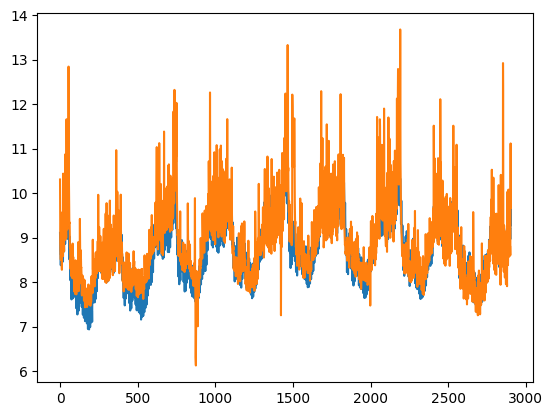

In [85]:

plt.plot(svi_samples["obs"].mean(axis=0).squeeze()[:, 1])
plt.plot(y_array.squeeze()[1])

In [43]:
plt.plot(svi_samples["hill"].mean(axis=0).squeeze()[0])
plt.plot(effect[0])

KeyError: 'hill'